# Condescension in NY Times Headlines
Gayatri Babel, Ayush Sehgal, Shreyans Sethi


## Standard Imports

In [107]:
!python -m nltk.downloader punkt
!pip install flair
!pip install transformers

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/willtholke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


In [108]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm
from transformers import BertModel, BertTokenizer
import torch
import torch.nn as nn
import random

In [109]:
def load_ordinal_data(filename, ordering):
    X = []
    Y = []
    orig_Y=[]
    for ordinal in ordering:
        Y.append([])
        
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            X.append(text)
            
            index=ordering.index(label)
            for i in range(len(ordering)):
                if index > i:
                    Y[i].append(1)
                else:
                    Y[i].append(0)
            orig_Y.append(label)
                    
    return X, Y, orig_Y



## Classifier Definition 

In [110]:
class OrdinalClassifier:

    def __init__(self, ordinal_values, feature_method, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY):
        self.ordinal_values=ordinal_values
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_regs = [None]* (len(self.ordinal_values)-1)

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.orig_trainY=orig_trainY
        self.orig_devY=orig_devY
        self.orig_testY=orig_testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

        self.predictions = []

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    def train(self):
        (D,F) = self.trainX.shape

        
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            best_dev_accuracy=0
            best_model=None
            for C in [0.0001, 0.001, 0.1, 1, 5, 10, 50, 100, 1000]:

                log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
                
                log_reg.fit(self.trainX, self.trainY[idx])
                development_accuracy = log_reg.score(self.devX, self.devY[idx])
                if development_accuracy > best_dev_accuracy:
                    best_dev_accuracy=development_accuracy
                    best_model=log_reg


            self.log_regs[idx]=best_model
        
    def test(self):
        cor=tot=0
        counts=Counter()
        preds=[None]*(len(self.ordinal_values)-1)
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            preds[idx]=self.log_regs[idx].predict_proba(self.testX)[:,1]
        
        preds=np.array(preds)
            
        for data_point in range(len(preds[0])):
    
            ordinal_preds=np.zeros(len(self.ordinal_values))
            for ordinal in range(len(self.ordinal_values)-1):
                if ordinal == 0:
                    ordinal_preds[ordinal]=1-preds[ordinal][data_point]
                else:
                    ordinal_preds[ordinal]=preds[ordinal-1][data_point]-preds[ordinal][data_point]

            ordinal_preds[len(self.ordinal_values)-1]=preds[len(preds)-1][data_point]

            prediction=np.argmax(ordinal_preds)

            self.predictions.append(prediction+1)

            counts[prediction]+=1
            if prediction == self.ordinal_values.index(self.orig_testY[data_point]):
                cor+=1
            tot+=1

        return cor/tot

## Featurizing the Data

In [111]:
# Feature 1: Length of the sentence the word is present in
def sentence_length(text):
  feats = {}
  words = nltk.word_tokenize(text)
  for word in words:
    feats[word] = len(words)
  
  return feats

In [112]:
# Feature 2: Presence of Punctuation in the Data
def punctuation(text):
    words = nltk.word_tokenize(text)
    feats = {}
    counts = {}
    puncs = ['.', ',', ';', ':']
    for word in words:
      if word in feats and word in puncs:
        feats[word] += 1
      elif word in puncs:
        feats[word] = 1

    return feats

In [113]:
# Feature 7: Calculates the NGram of the text
total_bigrams = {}
def NGram(text):
    feats = {}
    words = nltk.word_tokenize(text)
    N = 2
    for i in range(len(words)-N):
      gram = ""
      for n in range(1, N):
        gram += words[i] + " " + words[i + n]
        if gram in total_bigrams:
          total_bigrams[gram] += 1
        else:
          total_bigrams[gram] = 1
      feats[gram] = 1
            
    return feats

In [114]:
# Feature 9: Classic Bag of Words (provided)
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1
            
    return feats

In [115]:
# Combines all the features or a subset of them together (currently set to the features that produced the best model)
from nltk.util import ngrams
def combiner_function(text):
  all_feats={}
  for feature in [binary_bow_featurize, NGram]:
    all_feats.update(feature(text))
  return all_feats

In [116]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

## Training and Validation

In [117]:
def run(trainingFile, devFile, testFile, ordinal_values):
    trainX, trainY, orig_trainY = load_ordinal_data(trainingFile, ordinal_values)
    devX, devY, orig_devY = load_ordinal_data(devFile, ordinal_values)
    testX, testY, orig_testY = load_ordinal_data(testFile, ordinal_values)

    # Check if there is only one class in the data
    unique_classes = set(orig_trainY + orig_devY + orig_testY)
    if len(unique_classes) == 1:
        print("Only one class in the data, no need to train model.")
        return

    simple_classifier = OrdinalClassifier(ordinal_values, combiner_function, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)

    print("Training labels:", orig_trainY)
    print("Development labels:", orig_devY)
    print("Test labels:", orig_testY)

    simple_classifier.train()
    accuracy = simple_classifier.test()

    lower, upper = confidence_intervals(accuracy, len(testY[0]), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

In [121]:
trainingFile = "test-splits/train.txt"
devFile = "test-splits/dev.txt"
testFile = "test-splits/test.txt"
    
ordinal_values=["1", "2", "3"]

y_preds_test = run(trainingFile, devFile, testFile, ordinal_values)

IndexError: list index out of range

# **Test accuracy for best dev model: 0.790, 95% CIs: [0.734 0.846]**

## Code for Analysis

In [ ]:
#Using this to see the class proportions of both trainY and testY so we can see the imbalances

def get_class_proportions(labels):
  labels = [int(label) for label in labels]
  props = {}
  for i in range(5):
    props[i+1] = sum(np.asarray(labels) == (i+1)) / len(labels)
  return props

In [ ]:
trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
print("Label Proportions for Training Data")
print(get_class_proportions(orig_trainY))

testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)
print("Label Proportions for Test Data")
print(get_class_proportions(orig_testY))

Label Proportions for Training Data
{1: 0.7483333333333333, 2: 0.19833333333333333, 3: 0.041666666666666664, 4: 0.01, 5: 0.0016666666666666668}
Label Proportions for Test Data
{1: 0.755, 2: 0.2, 3: 0.03, 4: 0.01, 5: 0.005}


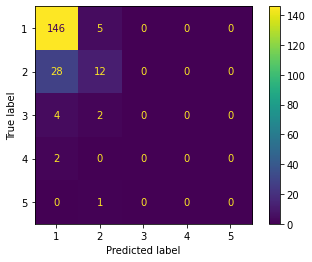

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)
orig_testY = [int(x) for x in orig_testY]
y_preds_test = [int(x) for x in y_preds_test]

cf = confusion_matrix(orig_testY, y_preds_test, labels = [1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = ['1','2','3','4','5'])
disp.plot();

In [ ]:
#Checking which words have the greatest TF-IDF Score
trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
dicts = [tf_idf(text) for text in trainX]
words_with_scores = {}
for feat_dict in dicts:
  for key in feat_dict:
    value = feat_dict[key]
    if key not in words_with_scores:
      words_with_scores[key] = value
    elif key in words_with_scores and value > words_with_scores[key]:
      words_with_scores[key] = value

dict(sorted(words_with_scores.items(), key=lambda item: item[1], reverse = True))

{'your': 19.190788965648437,
 'Hui': 19.190788965648437,
 'Nude': 19.190788965648437,
 'journalist': 15.894952099644108,
 'Egypt': 14.362475228346138,
 'Taiwan': 13.353058518482499,
 'Japan': 12.95246434060893,
 'Palestinian': 12.95246434060893,
 'Saudi': 12.95246434060893,
 'lion': 12.793859310432293,
 'Lula': 12.793859310432293,
 'Eid': 12.793859310432293,
 'airport': 12.793859310432293,
 'Nanaimo': 12.793859310432293,
 'Berkeley': 12.793859310432293,
 'Medal': 12.793859310432293,
 'Afford': 12.793859310432293,
 'Zimbabwe': 12.793859310432293,
 '737': 12.793859310432293,
 'Kimmel': 12.793859310432293,
 'Cruz': 12.793859310432293,
 'Bunga': 12.793859310432293,
 'harmony': 12.793859310432293,
 'Radio': 12.793859310432293,
 'Khan': 12.793859310432293,
 'Yoon': 12.793859310432293,
 'Ash': 12.793859310432293,
 'Helmand': 12.793859310432293,
 'lions': 12.793859310432293,
 'My': 12.793859310432293,
 'Ireland': 12.793859310432293,
 'Saint': 12.793859310432293,
 '37': 12.793859310432293,
 'Re

In [ ]:
#Investigating into the Common Bigrams
dict(sorted(total_bigrams.items(), key=lambda item: item[1], reverse = True))

{'’ s': 538,
 'of the': 158,
 'in the': 142,
 ', the': 95,
 ', but': 87,
 ', a': 85,
 ', and': 85,
 'of a': 75,
 'to the': 65,
 'in a': 65,
 'on the': 53,
 'the country': 44,
 '. But': 44,
 'for the': 40,
 '. The': 40,
 'the United': 37,
 'United States': 37,
 'Prime Minister': 36,
 'and the': 36,
 'that the': 35,
 'Hong Kong': 32,
 'as a': 32,
 'with the': 31,
 'and a': 31,
 'from the': 31,
 'by the': 31,
 'prime minister': 31,
 ', which': 30,
 'have been': 29,
 'has been': 28,
 ', who': 28,
 'to a': 28,
 'country ’': 27,
 '’ t': 27,
 ', ”': 26,
 'China ’': 25,
 'to be': 24,
 'at a': 24,
 'at the': 24,
 'on a': 23,
 ', has': 23,
 'President Trump': 22,
 'the first': 22,
 'more than': 22,
 'the government': 21,
 'he was': 21,
 'for a': 20,
 ', was': 20,
 'North Korea': 20,
 'U.S .': 20,
 'said the': 19,
 'had been': 19,
 'after a': 19,
 'the world': 19,
 ', where': 19,
 ', an': 18,
 ', in': 18,
 ', as': 18,
 ', is': 18,
 'at least': 18,
 'a new': 17,
 ', with': 17,
 'after the': 16,
 '

##Part B) Final Analysis Report

For our final model, we ended up going with an Ordinal Logistic Regression base classifier. Out of the box, this performed better than Logistic Regression as it made use of the nature of our labels. Ordinal Logistic Regression will take into consideration the fact that 1 and 2 have a set order and it is important to know that one rank is higher than the other, which Ordinal Logistic Regression helps us incorporate. Our final model had three features: bag of words, tf_idf scores, and Bigrams although a number of other features were tried (fully explained below). It reached a final test accuracy of 79%, which beats the baseline majority class classifier, which had an accuracy of 76%. 

Since we were using ordinal logistic regression, we wanted to focus on featurizing the dataset beyond using a simple Bag of Words model. We began with basic features such as the length of the data point and the counts of different punctuation in the data point as we believed that the usage of certain punctuation like exclamation or question marks would imply a stronger personal tone, which could be associated with condescension. However, these proved not to be predictive features and we observed this empirically as our test accuracy decreased to 70%. 

What we found surprising was that including NGrams as a feature worked well for us, the best one being a Bigram. This is likely because it broadens the scope of the words that we can attribute are unique to specific ranks. However, the drop when we increase this to a Trigram was a little unclear to us. It is likely because the countries and people that are referred to in the data points usually end to have two names in them, so they become helpful features.

We then added the TF-IDF count for each word as a feature and this (when used alongside BoW) increased our test accuracy from 75% to 77%. Since the TF-IDF weighs a word based on how infrequently it occurs, it makes sense how this would help the classifier as it can pay more attention to uncommon terms and by looking at the featurized training data, some of the words with the highest TF-IDF scores included “Your”, “Nude”, “Egypt”,  “journalist”, etc. In particular, the word with the highest TF-IDF score, “your”, is important to highlight as, given that the chosen articles were filtered for news articles, the presence of the second-person pronoun should be minimal. News articles tend to be objective and thus, written in the third-person; unless there is a high frequency of the pronoun within quotes, it should not be very frequent among the chosen data points (articles). For the future, considering pronouns (the author’s use of first-person and second-person pronouns) could aid in identifying articles with more bias and condescension and is something that classifier made us think about adding to our guidelines.

Another attempt with featurization was to try to create contextualized embeddings with BERT. We did this by using the pretrained Hugging Face model provided to us and we took an average of the word embedding for each word in that given datapoint to get one vector per data point. This turned out to not be as helpful as using features we specifically engineered, namely Bag of Words, TF-IDF scores, and Ngrams did better than BERT embeddings. Our benchmark for improvement was the majority class classifier which had an accuracy of 76%. 


Some of the more complicated features we tried to include were POS and NER tags for the data points and we used the Flair external library to get these. We included these as features by tagging each datapoint and then aggregating the count of each NER / POS tag and adding it to the features dictionary. For example, a datapoint could have 5 VB’s, 6 NNP’s, etc. Our hypothesis behind using these features was that there would be more ADJ and ADV (Adjective and Adverb) tags in more condescending data points since they may imply tone or additional commentary being made by the writer. However, this hypothesis turned out to not be true as our empirical test accuracy dropped by 5% after the addition of these features. Possible reasons for this could be that by aggregating the counts of these tags, we were not keeping information about their relative positioning in the sentence. Furthermore, all sentences are likely to have NER tags such as Persons, Locations, etc. since we were using global news data points. Lastly, with only 600 training points and by seeing that our training accuracy was higher than the test accuracy, we were overfitting. 


To combat the issue of losing information about the relative positioning of the POS tags, we created a function that combined the idea of N-grams with POS tags. Instead of creating a feature vector of the word n-grams, we did it with the POS tags and we tried a variety of n values (ranging from 2-5). The idea behind this was that if we see several adjectives right before a proper noun, it could be a more accurate indicator of tone and condescension. This did cause our accuracy to increase from the baseline 75% test accuracy (using just BoW) but was still not as useful as a word N-gram feature (reaching 79%). When used in conjunction with word n-grams, the accuracy dropped to 78% suggesting overfitting and we tried to combat this by using L1 and L2 regularization in the classifier but 78% remained the highest accuracy we achieved while including this feature.


Therefore, after trying many combinations of the above features and using regularization methods (especially L1 since we had limited data points and a lot of feature ideas), the best model remained the one that used the features of TF-IDF, Bag of Words and Bigrams, achieving a 79% test accuracy. We then investigated further into the mistakes our classifier was making and looked at the breakup of our data.

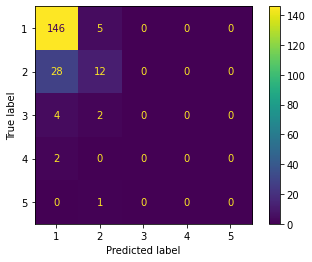

In [ ]:
disp.plot();

We first noted that the annotated dataset itself is extremely imbalanced. For example, across all of the annotated data, only 2 data points with a label of 5 exist; one of these data points was in the train dataset and the other was in the test dataset. Meanwhile, over 60% of the dataset was labeled as a 1. Overall, 1s comprised the majority of the dataset, with all other labels falling into the minority. It is likely due to this reason that the majority classifier performed well on the dataset and was difficult to beat in terms of accuracy; the heavy imbalance within the dataset made it inherently difficult to compensate through other model modifications (ex. class weights which we explain below)
 
This imbalance was reflected in the predictions. When the model was evaluated using a confusion matrix (shown above), it performed well in predicting data points with a ranking of 1; 146 true positives and 5 false positives. However, this accuracy dropped sharply for all other rankings. Out of 40 articles with true labels of 2, only 12 were accurate with a ranking of 2; the remaining 28 were incorrectly classified as 1s. Additionally, the model did not assign any data point a label higher than a 2. Thus, the remaining 9 data points that were classified as 3s, 4s, 5s, were also labeled as 1s and 2s. 
 
This approach of mainly predicting 1s and 2s still led the classifier to still have a relatively high final test accuracy because our dataset is really imbalanced with there being a majority of these data points. To address this problem we tried upsampling and downsampling. We did this specifically by adding a class_weights parameter to the LogisticRegression model initiation and made sure to increase the percentage of 3, 4, and 5 rankings, with more of an emphasis on 4 and 5. We also made sure to downsample the 1s and 2s. Our most extreme percentages were about 30% upsampling on 4 and 5 and 10% downsampling on the 1s. In the end, this did not really make a significant difference to the model performance. This was likely due to how imbalanced our dataset was to begin with as the likelihood of encountering a 4 or a 5, even with replacement, is highly unlikely and not frequent enough for the model to learn to differentiate between 1s or 2s and 3s, 4s, and 5s. Thus, the adding the class weight penalties would be fruitless to rectify the imbalanced dataset. 

It is important to note though that given the source of the data (the New York Times), conservative ratings of condescension would be preferred. Regardless though, for the future, it would be recommended to implement upsampling or downsampling into the initial dataset (before it is split into train and test data). Since the split was done for us, this was not something that could be implemented; however, adding more data points and upsampling to favor 4s and 5s. 

As a result, it will likely be hard to generalize this data to other domains like another News Source because that imbalance is so specific to the NY times and the specific articles that we happened to have sampled. It will be difficult to find another domain or dataset that has this specific imbalanced bias towards a ranking of 1s and 2s. However, by annotating datasets from other news sources using a similar annotation guideline and then training the same type of Ordinal classifier on said data, we may still experience success.